In [160]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier  # thuật toán knn
from sklearn.model_selection import train_test_split  # hàm phân tách dữ liệu
from sklearn.metrics import accuracy_score # hàm độ chính xác
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
import seaborn as sns
from scipy import stats

class KNearestNeighborsClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean', weights='uniform'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights

    def fit(self, X, y):
        self.X_fit_ = np.asarray(X)
        self.y_fit_ = np.asarray(y)

    def _calculate_distances(self, X):
        if self.metric == 'euclidean':
            X = np.expand_dims(X, 1)
            distances = np.linalg.norm(X - self.X_fit_, axis=-1)
        elif self.metric == 'manhattan':
            distances = np.sum(np.abs(X - self.X_fit_), axis=-1)
        return distances

    def _get_k_neighbors(self, X):
        distances = self._calculate_distances(X)
        neigh_ind = np.argsort(distances)[:, :self.n_neighbors]
        neigh_dist = np.asarray([np.take(distances[i], neigh_ind[i]) for i in range(neigh_ind.shape[0])])
        return neigh_dist, neigh_ind

    def _get_weights(self, dist):
        if self.weights in (None, 'uniform'):
            return None
        elif self.weights == 'distance':
            with np.errstate(divide='ignore'):
                dist = 1. / dist
            inf_mask = np.isinf(dist)
            inf_row = np.any(inf_mask, axis=1)
            dist[inf_row] = inf_mask[inf_row]
            return dist
        elif callable(self.weights):
            return self.weights(dist)

    def _weighted_mode(self, a, w, *, axis=0):
        if axis is None:
            a = np.ravel(a)
            w = np.ravel(w)
            axis = 0
        else:
            a = np.asarray(a)
            w = np.asarray(w)
        if a.shape != w.shape:
            w = np.full(a.shape, w, dtype=w.dtype)
        scores = np.unique(np.ravel(a)) # get ALL unique values
        testshape = list(a.shape)
        testshape[axis] = 1
        oldmostfreq = np.zeros(testshape)
        oldcounts = np.zeros(testshape)
        for score in scores:
            template = np.zeros(a.shape)
            ind = (a == score)
            template[ind] = w[ind]
            counts = np.expand_dims(np.sum(template, axis), axis)
            mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
            oldcounts = np.maximum(counts, oldcounts)
            oldmostfreq = mostfrequent
        return mostfrequent, oldcounts

    def predict(self, X):
        X_ = np.asarray(X)
        neigh_dist, neigh_ind = self._get_k_neighbors(X_)
        weights = self._get_weights(neigh_dist)
        if weights is None:
            mode, _ = stats.mode(self.y_fit_[neigh_ind], axis=1)
        else:
            mode, _ = self._weighted_mode(self.y_fit_[neigh_ind], weights, axis=1)
        mode = np.asarray(mode.ravel(), dtype=np.intp)
        return mode

    def score(self, X, y):
        predictions = self.predict(X)
        y = np.asarray(y)  # Chuyển đổi y thành numpy array
        correct = np.sum(y == predictions)
        return correct / float(len(y))


def get_accuracy(labels, predictions):
    labels = np.asarray(labels)
    predictions = np.asarray(predictions)
    correct = np.sum(labels == predictions)
    return (correct / float(len(labels))) * 100.0

def draw_varying_neighbor(X_train, y_train, X_test, y_test,
    model_class=KNearestNeighborsClassifier, weights='uniform'):
     #Setup arrays to store training and test accuracies
    neighbors = np.arange(1,20)
    train_accuracy =np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    
    for i,k in enumerate(neighbors):
     #Setup a knn classifier with k neighbors
        knn = model_class(n_neighbors=k, weights=weights)

     #Fit the model
        knn.fit(X_train, y_train)

     #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train, y_train)

        test_accuracy[i] = knn.score(X_test, y_test)
        
    plt.figure(figsize=(15,7))
    plt.title('k-NN Varying number of neighbors')
    plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label='Training accuracy')
    plt.legend()
    plt.xlabel('Number of neighbors')
    plt.ylabel('Accuracy')
    plt.show()

dataset_filename = "winequality.csv"
dataset = pd.read_csv(dataset_filename,delimiter=';')
print(f"[INFO] Dataset shape: {dataset.shape}")
dataset.head()


[INFO] Dataset shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [87]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


<Axes: xlabel='quality'>

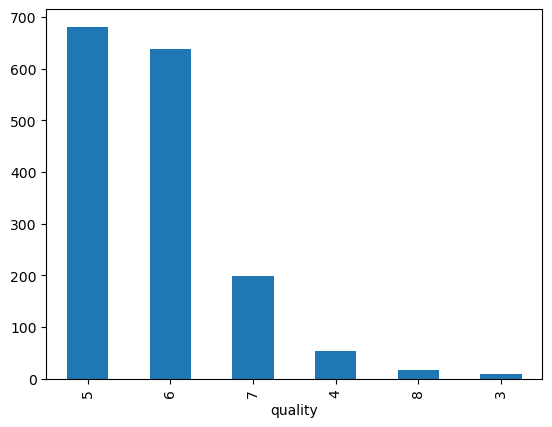

In [111]:
dataset['quality'].value_counts().plot(kind='bar')

In [89]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

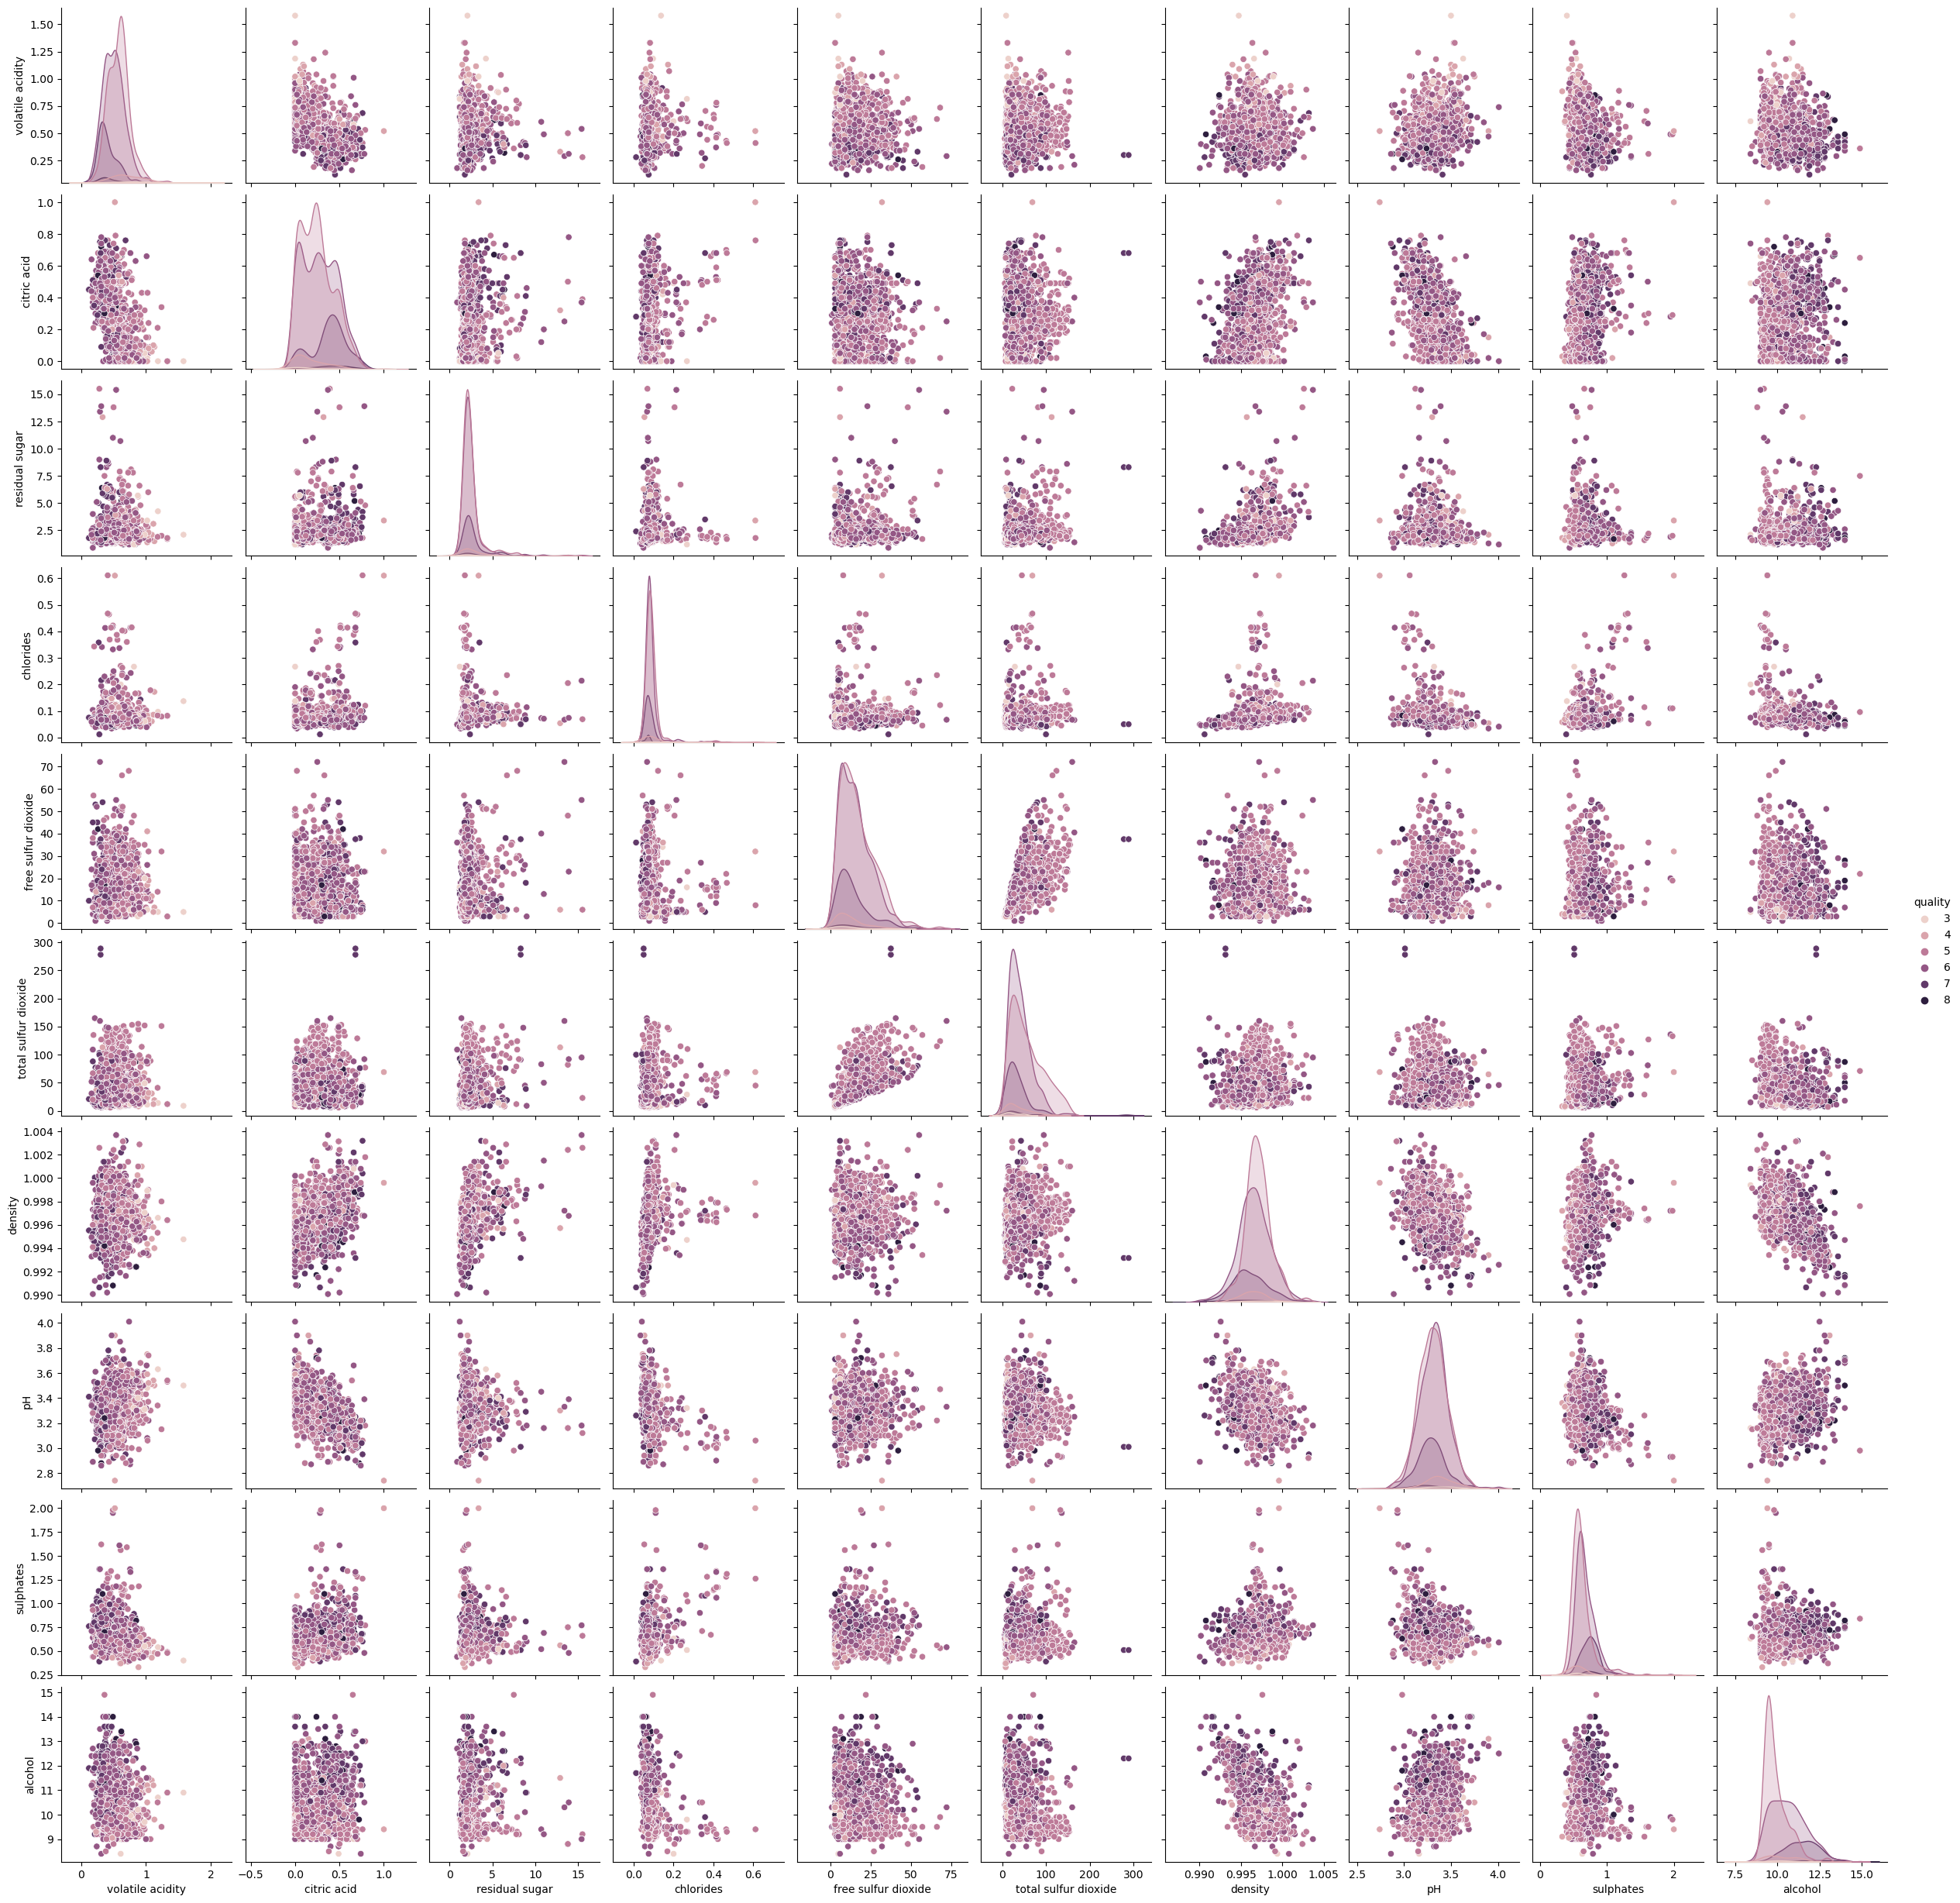

In [161]:
sns.pairplot(dataset.drop(columns='fixed acidity'), hue = 'quality',kind='scatter')
plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

Actual values:
[6 5 6 5 6 5 5 5 5 6 7 3 5 5 6 7 5 7 8 5 5 6 5 6 6 6 7 6 5 6 5 5 6 5 6 5 7
 5 4 6 5 5 7 5 5 6 7 6 5 6 5 5 5 7 6 6 6 5 5 5 5 7 5 6 6 5 6 5 6 5 6 4 6 6
 6 5 8 5 6 6 5 6 5 6 6 7 5 6 7 4 7 6 5 5 5 6 5 6 5 6 5 5 5 7 6 7 6 5 6 5 8
 5 6 5 6 7 6 6 5 6 6 6 6 6 6 6 7 6 5 5 6 5 5 5 6 5 5 5 5 6 7 6 8 5 5 5 6 6
 6 5 6 7 6 5 6 5 5 6 6 6 7 5 7 5 5 5 6 6 5 5 6 5 7 6 7 6 6 5 5 6 4 6 5 7 5
 5 4 5 7 6 5 6 6 7 6 5 5 6 5 7 5 6 6 5 7 5 5 5 6 7 7 5 5 6 6 7 6 5 6 6 6 6
 6 7 4 5 5 7 5 5 5 5 6 6 5 7 5 6 6 6 5 4 6 7 6 7 5 6 6 5 5 6 5 6 4 5 6 6 5
 6 6 5 5 6 7 7 6 5 6 6 5 6 5 6 5 5 5 6 6 6 7 5 5 6 5 7 5 6 4 6 6 8 6 5 5 6
 5 7 6 6 5 5 7 6 6 5 6 6 5 7 6 6 6 6 5 6 5 5 6 4]

Predicted values:
[6 5 6 6 6 6 5 5 5 5 8 5 6 6 6 7 5 6 7 6 7 5 5 6 5 6 5 5 5 6 5 5 5 5 5 5 6
 6 6 6 6 5 6 5 5 5 6 6 5 6 5 5 5 5 5 5 6 5 6 6 5 5 6 5 6 6 6 5 5 6 5 5 6 5
 6 5 5 5 5 5 5 5 7 5 6 5 5 6 6 5 5 5 5 5 5 6 6 4 5 5 5 5 6 6 6 6 6 6 5 5 6
 5 7 5 6 6 6 5 5 6 5 5 6 5 5 5 6 6 5 6 6 6 5 7 6 5 6 5 6 6 5 5 6 6 5 5 6 7
 5 5 5 6 5 5 6 6

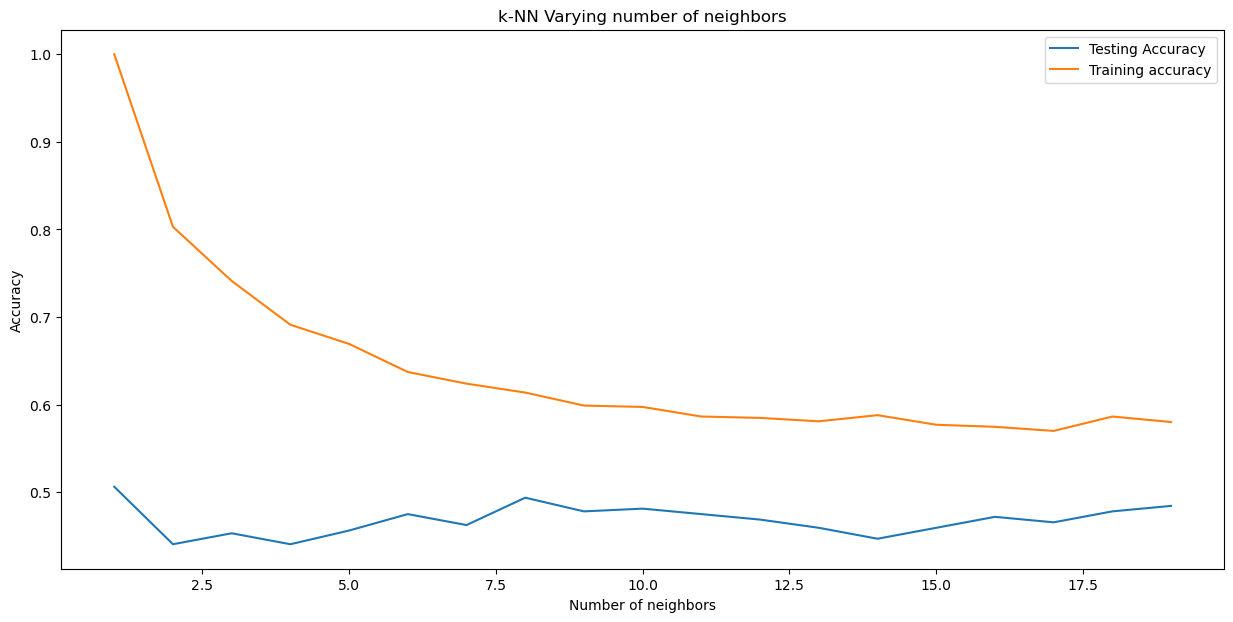

In [173]:
# Chuẩn bị dữ liệu
X = dataset.drop('quality', axis=1)
y = dataset['quality']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình
knn_model = KNearestNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Dự đoán
predictions = knn_model.predict(X_test)

# In kết quả
print("Actual values:")
print(y_test.values)
print("\nPredicted values:")
print(predictions)
print("\nAccuracy: {:.2f}%".format(get_accuracy(y_test.values, predictions)))

# Vẽ biểu đồ độ chính xác với số lượng neighbors khác nhau

draw_varying_neighbor(X_train, y_train, X_test, y_test)

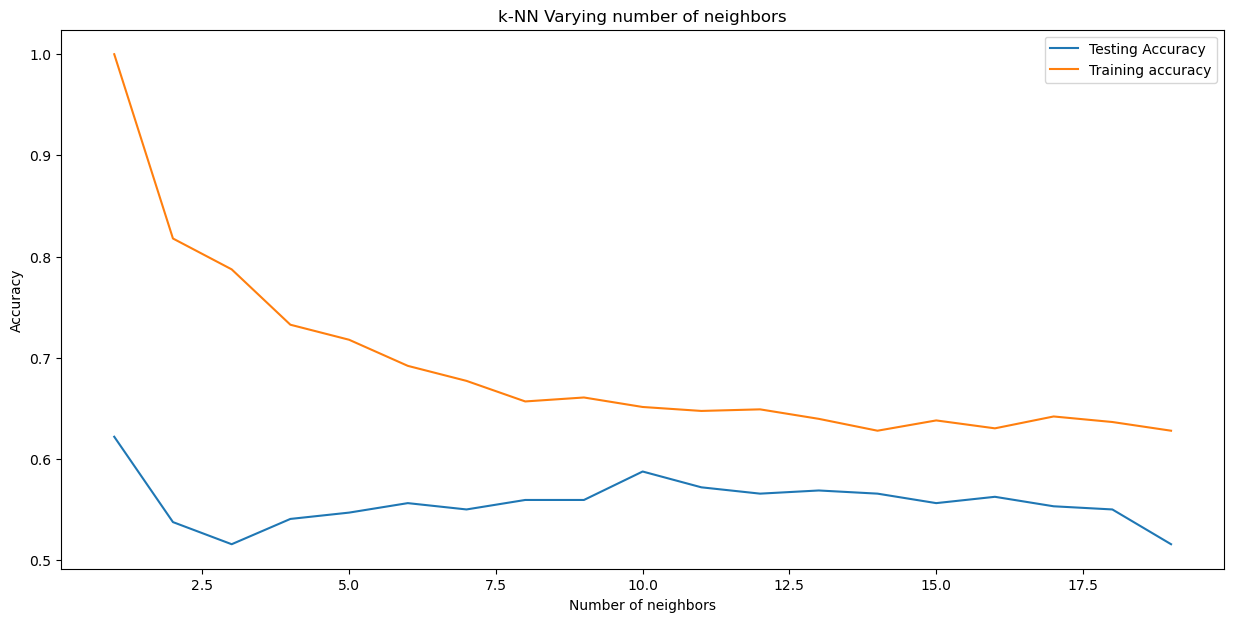

In [125]:
#Thay đổi giá trị k tìm giá trị tốt nhất không chuẩn hóa dữ liệu
draw_varying_neighbor(X_train_scaled, y_train, X_test_scaled, y_test)

Actual values:
[6 5 6 5 6 5 5 5 5 6 7 3 5 5 6 7 5 7 8 5 5 6 5 6 6 6 7 6 5 6 5 5 6 5 6 5 7
 5 4 6 5 5 7 5 5 6 7 6 5 6 5 5 5 7 6 6 6 5 5 5 5 7 5 6 6 5 6 5 6 5 6 4 6 6
 6 5 8 5 6 6 5 6 5 6 6 7 5 6 7 4 7 6 5 5 5 6 5 6 5 6 5 5 5 7 6 7 6 5 6 5 8
 5 6 5 6 7 6 6 5 6 6 6 6 6 6 6 7 6 5 5 6 5 5 5 6 5 5 5 5 6 7 6 8 5 5 5 6 6
 6 5 6 7 6 5 6 5 5 6 6 6 7 5 7 5 5 5 6 6 5 5 6 5 7 6 7 6 6 5 5 6 4 6 5 7 5
 5 4 5 7 6 5 6 6 7 6 5 5 6 5 7 5 6 6 5 7 5 5 5 6 7 7 5 5 6 6 7 6 5 6 6 6 6
 6 7 4 5 5 7 5 5 5 5 6 6 5 7 5 6 6 6 5 4 6 7 6 7 5 6 6 5 5 6 5 6 4 5 6 6 5
 6 6 5 5 6 7 7 6 5 6 6 5 6 5 6 5 5 5 6 6 6 7 5 5 6 5 7 5 6 4 6 6 8 6 5 5 6
 5 7 6 6 5 5 7 6 6 5 6 6 5 7 6 6 6 6 5 6 5 5 6 4]

Predicted values:
[5 5 6 6 6 5 5 5 6 6 7 6 6 5 5 7 5 5 7 5 4 6 5 6 5 6 6 6 5 6 5 5 5 5 5 5 6
 6 5 5 6 5 6 5 6 6 7 6 5 5 5 5 6 7 5 5 6 5 6 5 6 5 5 5 7 6 6 6 7 5 6 6 6 5
 6 5 7 5 6 7 5 7 5 5 6 6 5 6 7 6 6 5 5 6 5 5 5 6 5 6 6 5 6 6 6 6 6 5 5 5 7
 5 6 5 5 6 5 5 5 6 6 5 6 5 5 6 6 5 5 5 6 5 5 6 5 5 5 5 5 6 6 6 5 5 6 5 5 3
 6 5 6 6 5 5 6 6

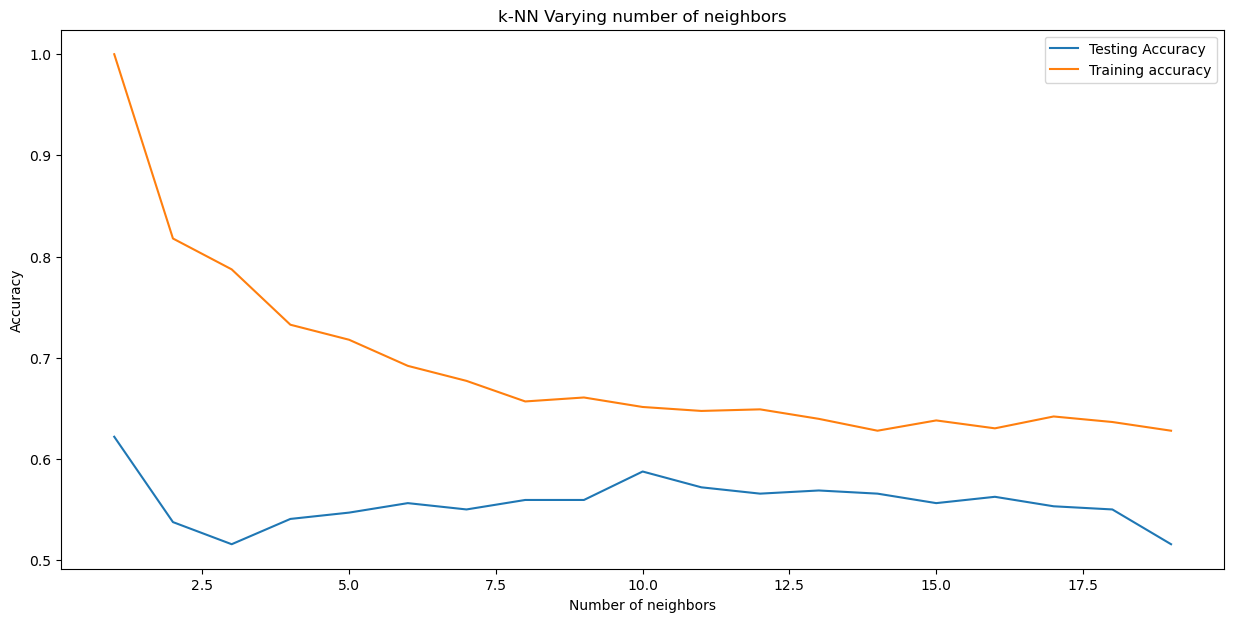

In [126]:
# Chuẩn bị dữ liệu
X = dataset.drop('quality', axis=1)
y = dataset['quality']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Khởi tạo và huấn luyện mô hình
knn_model = KNearestNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_norm, y_train)

# Dự đoán
predictions = knn_model.predict(X_test_norm)

# In kết quả
print("Actual values:")
print(y_test.values)
print("\nPredicted values:")
print(predictions)
print("\nAccuracy: {:.2f}%".format(get_accuracy(y_test.values, predictions)))

# Vẽ biểu đồ độ chính xác với số lượng neighbors khác nhau
draw_varying_neighbor(X_train_norm, y_train, X_test_norm, y_test)

In [178]:
# Chọn K tốt nhất
# Tạo model (k = 10)
knn_best = KNearestNeighborsClassifier(n_neighbors=10)
# Fitting the model
knn_best.fit(X_train_norm, y_train)
predictions = knn_best.predict(X_test)
print(y_test)
print(predictions)
print("Accuracy: ", get_accuracy(y_test, predictions), "%")


803     6
124     5
350     6
682     5
1326    6
       ..
1259    6
1295    5
1155    5
963     6
704     4
Name: quality, Length: 320, dtype: int64
[5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 7 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 7 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 6 5 5 5 6
 5 6 5 6 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 7 5
 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 7 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5]
Accuracy:  40.625 %


In [130]:
# Đánh trọng số “distance” cho các điểm lân cận
knn_model = KNearestNeighborsClassifier(n_neighbors=3,
weights='distance')
knn_model.fit(X_train_norm, y_train)
predictions = knn_model.predict(X_test_norm)
print(y_test)
print(predictions)
print("Accuracy with weight sigma: ", get_accuracy(y_test,
predictions), "%")

803     6
124     5
350     6
682     5
1326    6
       ..
1259    6
1295    5
1155    5
963     6
704     4
Name: quality, Length: 320, dtype: int64
[5 5 6 7 6 5 5 5 6 6 7 6 6 5 6 7 5 7 7 5 5 6 5 6 5 6 6 6 5 6 5 5 6 6 6 5 6
 6 6 6 5 5 8 5 6 6 7 6 5 7 5 5 6 7 5 6 6 5 6 5 5 6 6 5 7 5 6 6 7 6 6 6 6 5
 6 5 7 5 6 7 5 7 5 6 6 6 5 6 7 6 6 5 5 5 5 6 5 6 7 5 6 5 6 7 6 7 6 5 6 5 6
 5 7 5 5 6 6 6 5 6 6 6 5 6 6 6 7 5 5 5 6 5 5 6 7 5 5 6 5 6 7 5 7 6 6 5 5 6
 6 5 6 6 6 5 6 5 5 5 5 6 5 6 6 5 5 6 6 5 5 5 5 5 5 6 7 6 6 5 6 5 5 5 6 7 5
 6 6 6 7 6 6 6 5 6 6 5 5 6 5 7 5 5 5 5 6 6 5 6 6 7 8 5 5 6 7 7 6 5 6 6 6 6
 6 6 6 5 6 7 6 6 6 4 7 5 5 7 5 6 6 5 6 5 6 7 6 7 5 6 7 5 5 5 5 5 3 5 5 7 6
 6 7 4 5 7 6 5 6 5 6 6 5 6 5 6 6 5 6 6 6 6 7 6 5 5 5 7 5 5 6 6 5 6 8 5 5 6
 5 7 6 7 5 5 7 5 6 5 6 6 6 7 6 4 6 5 6 6 5 5 6 6]
Accuracy with weight sigma:  62.5 %


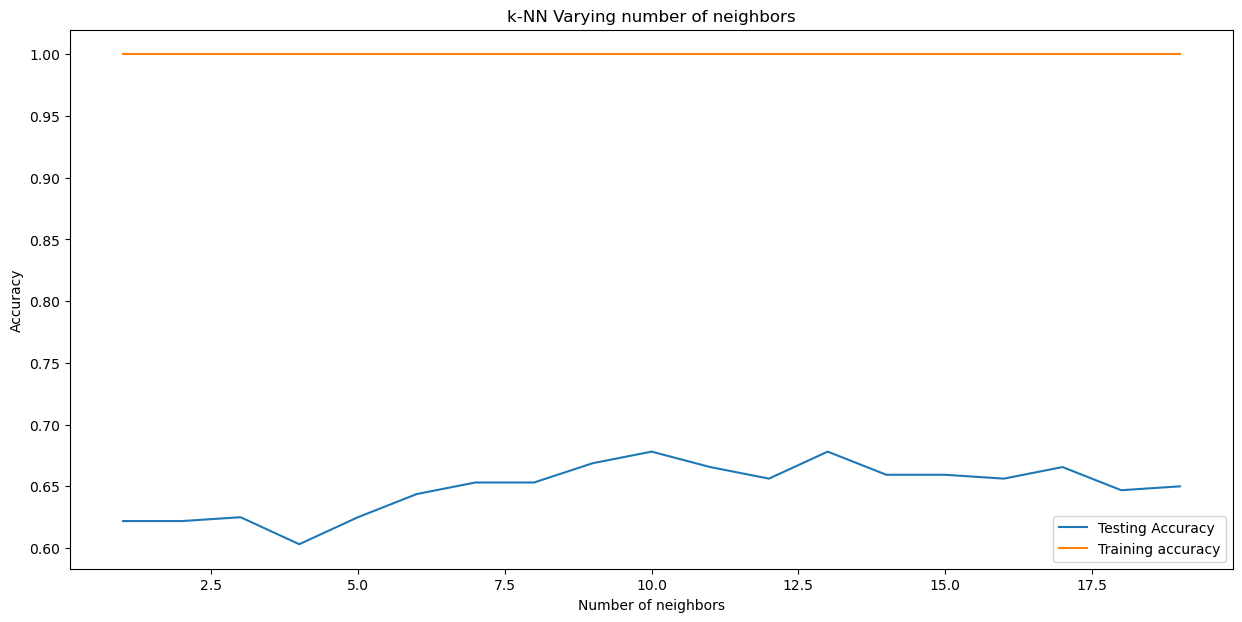

In [131]:
draw_varying_neighbor(X_train_norm, y_train, X_test_norm, y_test,
weights='distance')

In [139]:
# Định nghĩa hàm trọng số tùy chỉnh
def myweight(distances):
    sigma2 = .5 # we can change this number
    return np.exp(-distances**2/sigma2)
knn_model = KNearestNeighborsClassifier(n_neighbors=3,
weights=myweight)
knn_model.fit(X_train_norm, y_train)
predictions = knn_model.predict(X_test_norm)
print(y_test)
print(predictions)
print("Accuracy with weight sigma: ", get_accuracy(y_test,predictions), "%")

803     6
124     5
350     6
682     5
1326    6
       ..
1259    6
1295    5
1155    5
963     6
704     4
Name: quality, Length: 320, dtype: int64
[5 5 6 7 6 5 5 5 6 6 7 6 6 5 6 7 5 7 7 5 5 6 5 6 5 6 6 6 5 6 5 5 6 6 5 5 6
 6 6 6 5 5 6 5 6 6 7 6 5 7 5 5 6 7 5 6 6 6 6 5 5 6 6 5 7 6 6 5 7 6 6 3 6 6
 6 5 7 5 5 7 5 7 5 6 6 6 5 6 7 6 6 5 5 5 5 5 5 6 7 5 6 5 6 7 6 7 6 5 6 5 7
 5 7 5 5 6 5 6 5 6 6 6 5 6 6 6 7 6 5 5 6 5 5 6 7 5 5 6 5 6 7 5 7 6 6 5 5 6
 5 5 6 6 6 5 6 5 5 5 5 6 5 6 6 5 5 6 6 5 5 5 5 5 7 6 7 5 6 5 6 5 4 5 6 7 5
 6 6 6 7 6 6 6 5 7 6 5 5 6 5 7 5 5 5 5 6 6 5 6 6 7 8 5 5 6 7 7 6 5 7 6 6 6
 6 6 6 3 6 7 6 6 6 4 7 5 5 7 5 6 6 5 6 5 6 7 6 7 4 6 7 5 6 5 5 5 3 5 5 7 6
 6 7 4 5 7 6 5 6 5 6 6 5 6 5 6 6 5 6 6 6 6 7 6 5 5 5 7 5 5 6 6 6 6 8 5 5 6
 5 7 6 7 5 5 7 5 6 5 6 6 6 7 6 4 6 5 6 6 5 5 6 6]
Accuracy with weight sigma:  60.9375 %


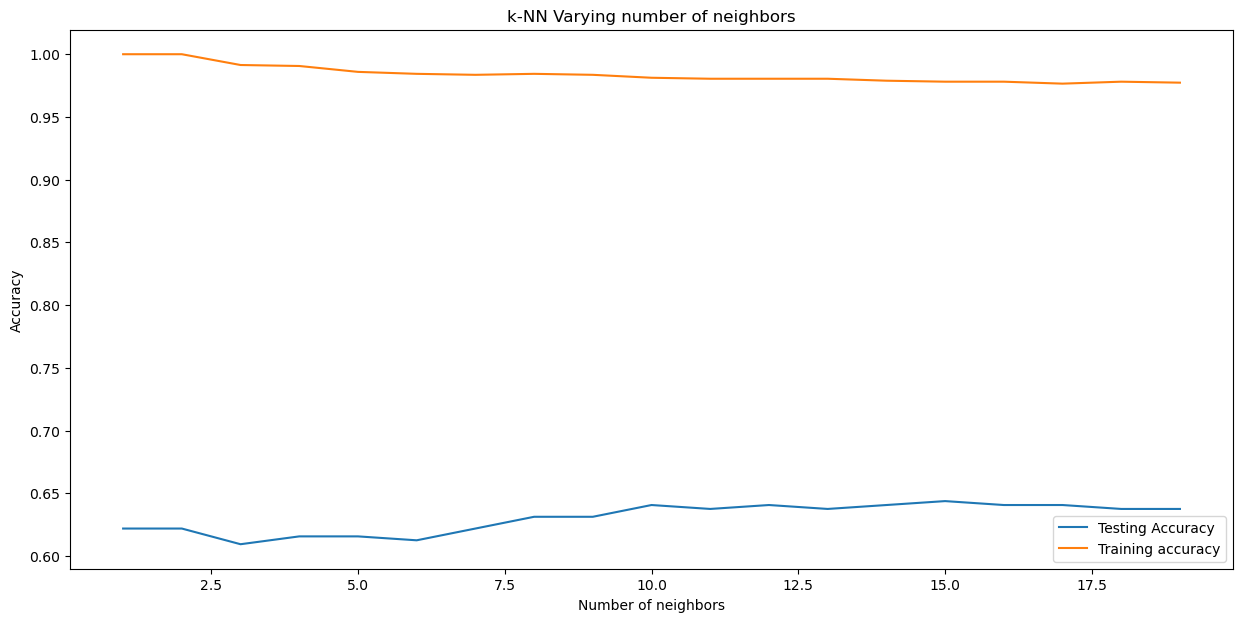

In [140]:
draw_varying_neighbor(X_train_norm, y_train, X_test_norm, y_test,
weights=myweight)

In [172]:
# 9.4 so sánh kết quả của thư viện sklearn
# 9.4.1 Dự đoán	kết	quả tập	test	dùng	mô	hình	Knn

knn_model_sk = KNeighborsClassifier(n_neighbors=14)
knn_model_sk.fit(X_train_norm, y_train)
predictions_sk = knn_model_sk.predict(X_test)
# In kết quả
print("Actual values:")
print(y_test.values)
print("\nPredicted values:")
print(predictions_sk)
print("Accuracy: ", get_accuracy(y_test, predictions_sk), "%")

Actual values:
[6 5 6 5 6 5 5 5 5 6 7 3 5 5 6 7 5 7 8 5 5 6 5 6 6 6 7 6 5 6 5 5 6 5 6 5 7
 5 4 6 5 5 7 5 5 6 7 6 5 6 5 5 5 7 6 6 6 5 5 5 5 7 5 6 6 5 6 5 6 5 6 4 6 6
 6 5 8 5 6 6 5 6 5 6 6 7 5 6 7 4 7 6 5 5 5 6 5 6 5 6 5 5 5 7 6 7 6 5 6 5 8
 5 6 5 6 7 6 6 5 6 6 6 6 6 6 6 7 6 5 5 6 5 5 5 6 5 5 5 5 6 7 6 8 5 5 5 6 6
 6 5 6 7 6 5 6 5 5 6 6 6 7 5 7 5 5 5 6 6 5 5 6 5 7 6 7 6 6 5 5 6 4 6 5 7 5
 5 4 5 7 6 5 6 6 7 6 5 5 6 5 7 5 6 6 5 7 5 5 5 6 7 7 5 5 6 6 7 6 5 6 6 6 6
 6 7 4 5 5 7 5 5 5 5 6 6 5 7 5 6 6 6 5 4 6 7 6 7 5 6 6 5 5 6 5 6 4 5 6 6 5
 6 6 5 5 6 7 7 6 5 6 6 5 6 5 6 5 5 5 6 6 6 7 5 5 6 5 7 5 6 4 6 6 8 6 5 5 6
 5 7 6 6 5 5 7 6 6 5 6 6 5 7 6 6 6 6 5 6 5 5 6 4]

Predicted values:
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5

D:\Anaconda\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


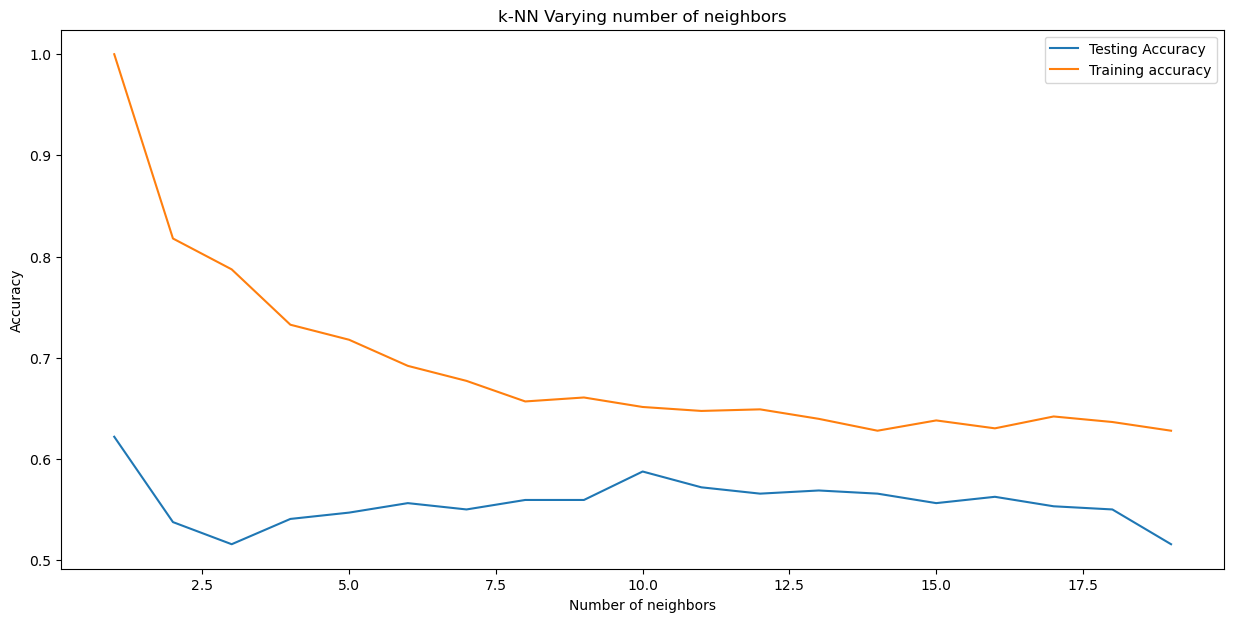

In [142]:
# 9.4.2. Thay đổi k tìm giá trị tốt nhất
draw_varying_neighbor(X_train_norm, y_train, X_test_norm, y_test,
model_class=KNeighborsClassifier)

In [179]:
# chọn k tốt nhất k = 10

# Tạo model (k = 10)
classifier = KNeighborsClassifier(n_neighbors=10)
# Fitting the model
classifier.fit(X_train_norm, y_train)
# Predicting on the test set
y_pred = classifier.predict(X_test)
print(f"Labels: {y_test}")
print(f"Predictions: {y_pred}")
print(f"Accuracy is: {accuracy_score(y_test, y_pred)*100}%")

Labels: 803     6
124     5
350     6
682     5
1326    6
       ..
1259    6
1295    5
1155    5
963     6
704     4
Name: quality, Length: 320, dtype: int64
Predictions: [5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 7 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 7 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 6 5 5 5 6
 5 6 5 6 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 7 5
 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 7 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5]
Accuracy is: 40.625%


D:\Anaconda\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

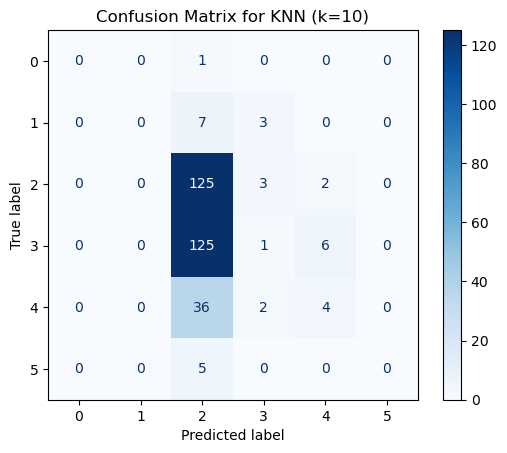

Confusion Matrix:
[[  0   0   1   0   0   0]
 [  0   0   7   3   0   0]
 [  0   0 125   3   2   0]
 [  0   0 125   1   6   0]
 [  0   0  36   2   4   0]
 [  0   0   5   0   0   0]]


In [181]:
cm = confusion_matrix(y_test, y_pred)

# Tạo ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Vẽ confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN (k=10)')
plt.show()

# In ra confusion matrix dưới dạng số
print("Confusion Matrix:")
print(cm)

In [156]:
# 9.4.3. Đánh	trọng	số cho	các	điểm	lân	cận
knn_model_weight = KNeighborsClassifier(n_neighbors = 7, p = 2,
weights = 'distance')
knn_model_weight.fit(X_train_norm, y_train)
y_pred = knn_model_weight.predict(X_test)

print("Accuracy of 10NN (1/distance weights): %.2f %%"
%(100*accuracy_score(y_test, y_pred)))

Accuracy of 10NN (1/distance weights): 40.62 %


D:\Anaconda\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


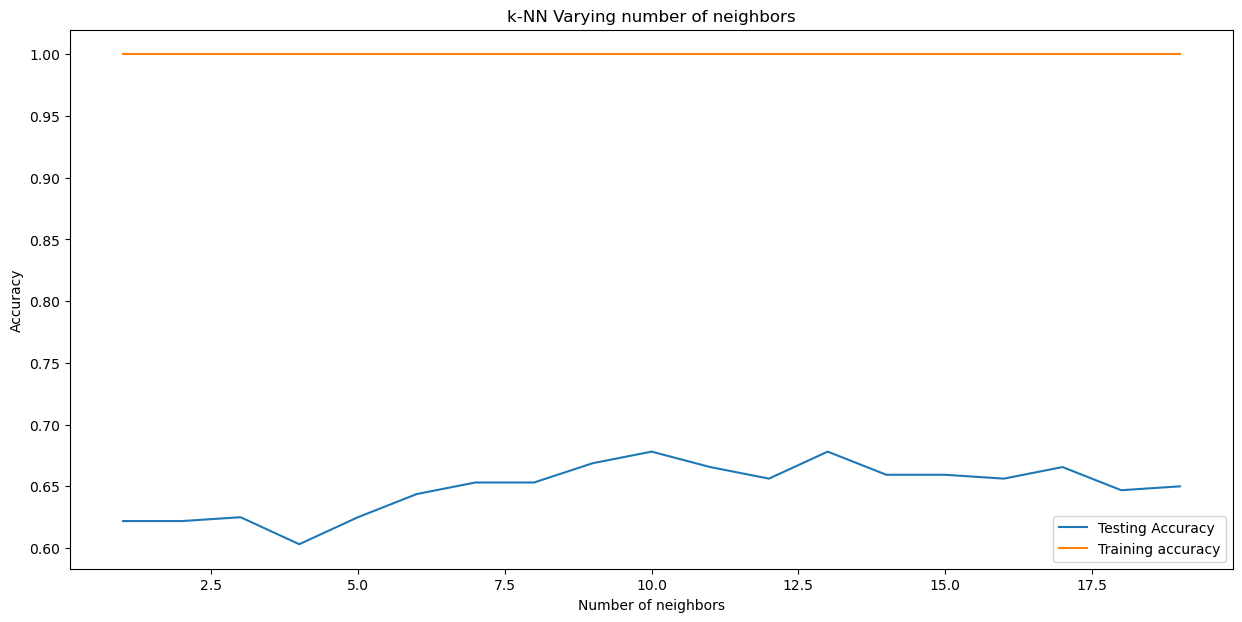

In [157]:

draw_varying_neighbor(X_train_norm, y_train, X_test_norm, y_test,
model_class=KNeighborsClassifier, weights = 'distance')


In [158]:
# Đánh	trọng	số tự chọn
def myweight(distances):
    sigma2 = .5 # we can change this number
    return np.exp(-distances**2/sigma2)
knn_model_custom_weight = KNeighborsClassifier(n_neighbors = 5, p =
2, weights = myweight)
knn_model_custom_weight.fit(X_train_norm, y_train)
y_pred = knn_model_custom_weight.predict(X_test_norm)
print("Accuracy of 10NN (customized weights): %.2f %%"
%(100*accuracy_score(y_test, y_pred)))

Accuracy of 10NN (customized weights): 61.56 %


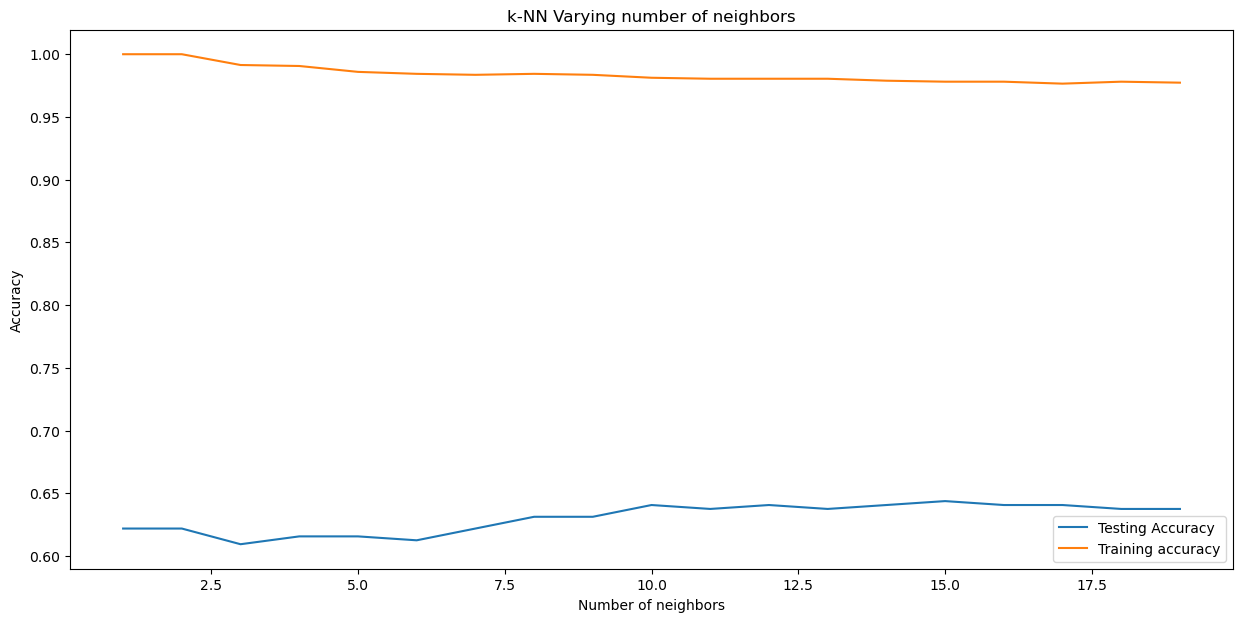

In [159]:
draw_varying_neighbor(X_train_norm, y_train, X_test_norm, y_test,
model_class=KNeighborsClassifier, weights = myweight)